In [1]:
import netsim_summariser as summ

from importlib import reload
reload(summ)

<module 'netsim_summariser' from '/home/davidwu/REPOS/echidna_network/netsim_summariser.py'>

In [81]:
import itertools
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

In [2]:
summarise_snapshots = summ.Summariser("./zero_sims/snapshot/sim_all.h5")

snapshot_results = summarise_snapshots.collect(over=None, ncpus=6, no_move=True, verbose=False)

snapshot_df = summarise_snapshots.results_to_polars(snapshot_results, drop=[])

<Axes: xlabel='seed', ylabel='extent'>

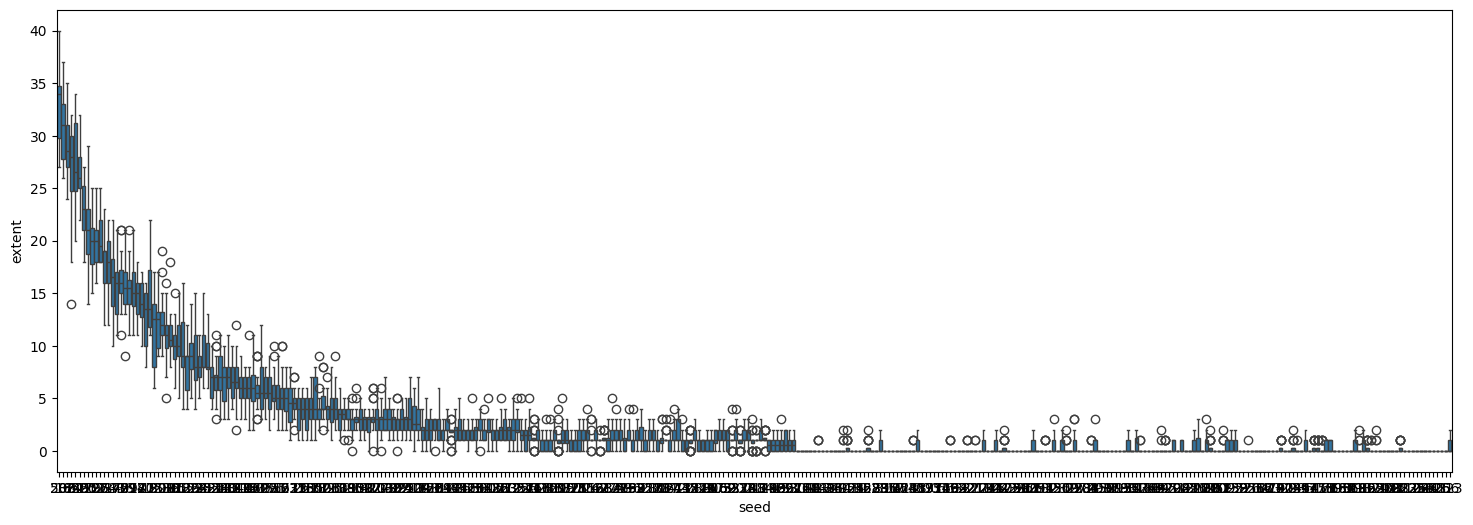

In [35]:
fig, ax = plt.subplots(figsize=(18, 6))

snapshot_median_extent = snapshot_df.group_by('seed').median().select('seed', 'extent')
sorder = snapshot_median_extent.sort('extent', descending=True).select('seed').to_series().to_list()

sns.boxplot(
    snapshot_df.select('seed', 'extent'),
    x='seed',
    y='extent',
    order=sorder,
    orient='v',
    ax=ax,
)

In [27]:
summ_statichome = summ.Summariser("./zero_sims/static/sim_all.h5")

statichome_results = summ_statichome.collect(over=None, ncpus=6, no_move=True, verbose=False)

statichome_df = summ_statichome.results_to_polars(statichome_results, drop=[])

<Axes: xlabel='seed', ylabel='extent'>

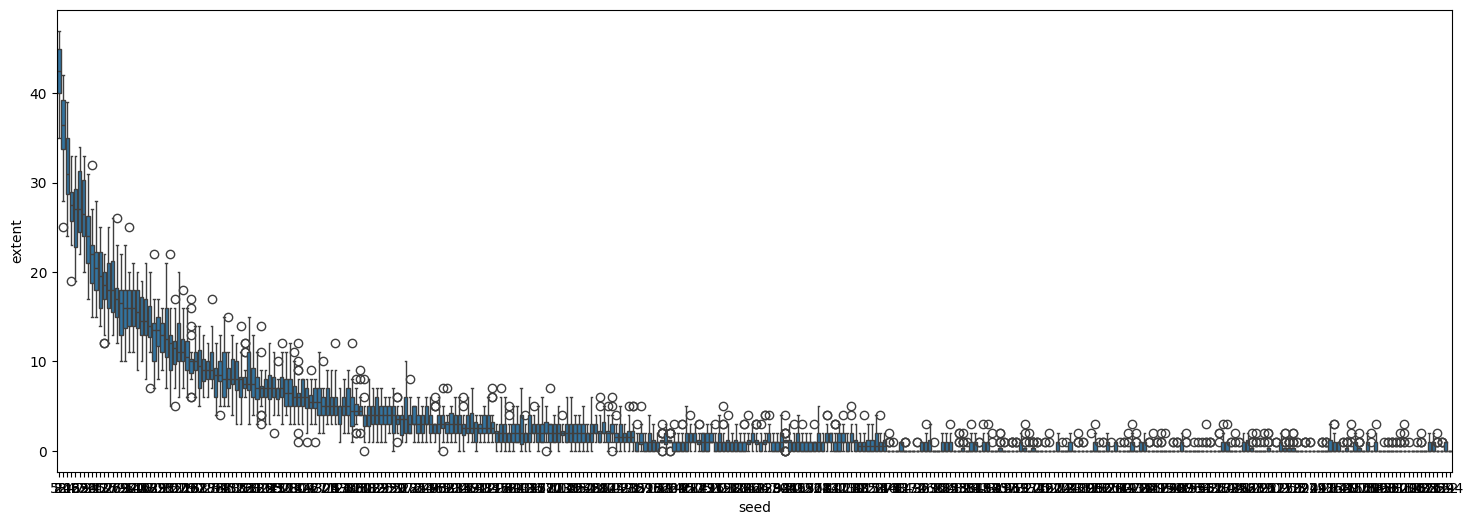

In [36]:
fig, ax = plt.subplots(figsize=(18, 6))

statichome_median_extent = statichome_df.group_by('seed').median().select('seed', 'extent')
shorder = statichome_median_extent.sort('extent', descending=True).select('seed').to_series().to_list()

sns.boxplot(
    statichome_df.select('seed', 'extent'),
    x='seed',
    y='extent',
    order=shorder,
    orient='v',
    ax=ax,
)

In [31]:
summ_temporal = summ.Summariser("zero_sims/temporal/all_sims.h5")

temporal_results = summ_temporal.collect(over=None, no_move=True, verbose=False)

temporal_df = summ_temporal.results_to_polars(temporal_results, drop=())

<Axes: xlabel='seed', ylabel='extent'>

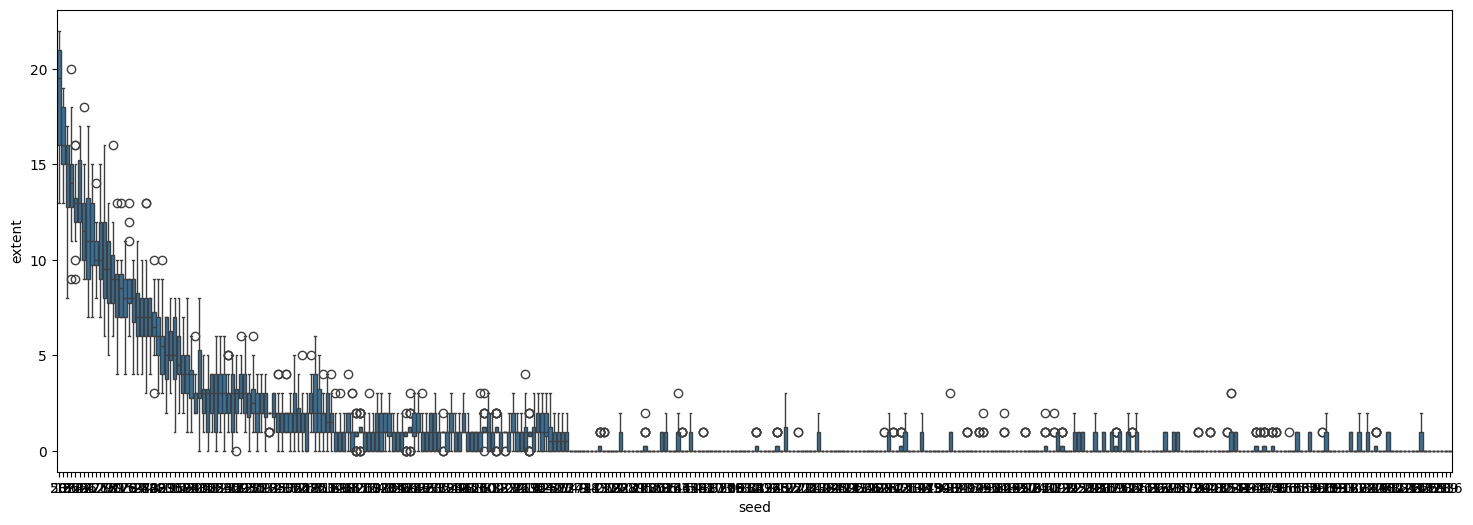

In [37]:
fig, ax = plt.subplots(figsize=(18, 6))

temporal_median_extent = temporal_df.group_by('seed').median().select('seed', 'extent')
torder = temporal_median_extent.sort('extent', descending=True).select('seed').to_series().to_list()

sns.boxplot(
    temporal_df.select('seed', 'extent'),
    x='seed',
    y='extent',
    order=torder,
    orient='v',
    ax=ax,
)

In [60]:
combined_median_df = pl.concat(
    [df.with_columns(pl.lit(label).alias('simulation'))
     for label, df in zip(['static', 'snapshot', 'temporal'], [statichome_median_extent, snapshot_median_extent, temporal_median_extent])]
)

combined_sort_order = combined_median_df.group_by('seed').median().select('seed', 'extent').sort('extent', descending=True).select('seed').with_row_index('sorted_seed')

combined_median_df = combined_median_df.join(combined_sort_order, on='seed')

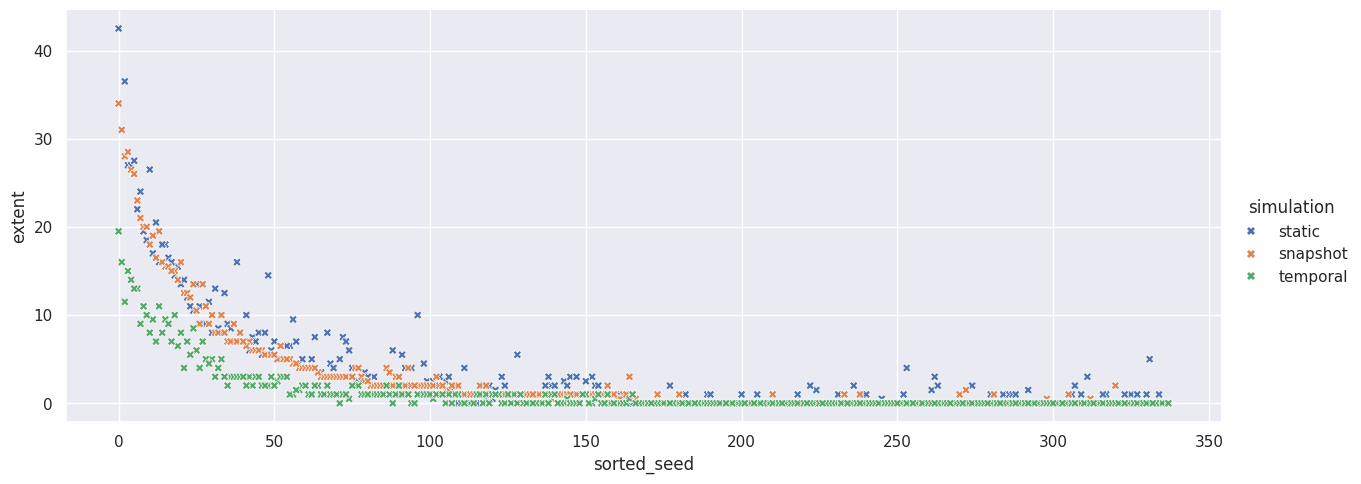

In [67]:
sns.relplot(
    combined_median_df,
    x='sorted_seed',
    y='extent',
    hue='simulation',
    marker='X',
    aspect=2.5,
).savefig("zero_extent_median_comparison.png", dpi=200)


In [70]:
paired_median_df = combined_median_df.pivot("simulation", index="sorted_seed", values="extent")

In [86]:
for p1, p2 in itertools.combinations(['static', 'snapshot', 'temporal'], 2):
    print(p1, 'vs', p2)
    print(stats.ttest_rel(paired_median_df[p1], paired_median_df[p2], alternative='two-sided'))

static vs snapshot
TtestResult(statistic=5.732195290326988, pvalue=2.202681065306734e-08, df=337)
static vs temporal
TtestResult(statistic=10.697618565837029, pvalue=3.449912224603156e-23, df=337)
snapshot vs temporal
TtestResult(statistic=10.11284593583733, pvalue=3.59419735308058e-21, df=337)


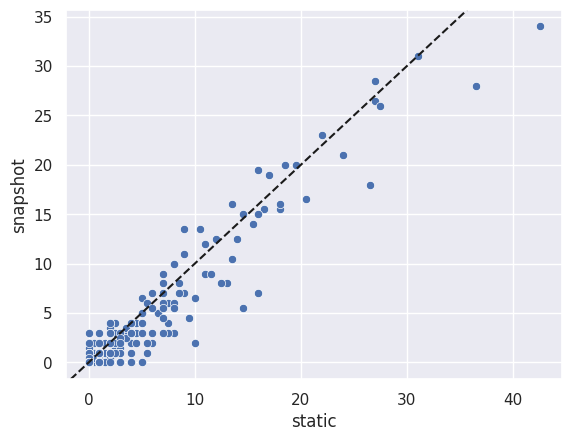

In [76]:
sns.scatterplot(paired_median_df, x='static', y='snapshot')
plt.axline((0,0), slope=1, color='k', linestyle='dashed')